In [2]:
import pandas as pd
import numpy as np
import csv
import random
import ast

from scipy import stats, integrate
import matplotlib.pyplot as plt
import re
import nltk
from nltk.probability import FreqDist

import seaborn as sns
sns.set(color_codes=True)

import scrapeMyProf as smp
%load_ext autoreload
%autoreload 2

%matplotlib inline

Things to do in near future
* Scraping: Scrape reviewer id as well
looks like <tr id="27765702" class = "">
* Scrape additional states

Ultimate goals
* Create a recommendation engine. Let user input liked & disliked professors, and create a recommendation engine (across university, in specific department).
* Look up a professor, predict average overall/difficulty based on department/gender/school. Get the deviation from that amount. Extract important sentences or words. Purpose: evaluate individual teaching in the correct playing field.
* Same for schools, deviations could give information to schools, prospective students.

Possible things to do
* Clustering of department names to group departments
* Difficulty vs Overall for men vs. women (linear regression)
* Consider the gender of reviewer (would need to predict reviewer gender)

# Setup for Multiple States, include School & State

The data will need some cleaning up and the addition of gender and number of pronouns corresponding to that gender. Eliminate any professors with gender unknown. Add the name city state of school. This takes a while, so if it has already been done, simply load the data, filename for state with '_cleanGender.csv' at the end.

In [273]:
# Pull in RI profs, clean up, add gender and number of pronouns
review_df = smp.cleanAddGender_csv('../smp_data/RI_profs_021717',colHeader)

In [275]:
# Pull in NH profs
NH_df = smp.cleanAddGender_csv('../smp_data/NH_profs_021917',colHeader)

# Pull in ME profs
ME_df = smp.cleanAddGender_csv('../smp_data/ME_profs_022117',colHeader)

In [276]:
# Combine all states
review_df = review_df.append(NH_df,ignore_index=True).append(ME_df,ignore_index=True)

In [386]:
# Some initial combining of department names -- need to do this more systematically and automatically
review_df.replace({'department':{'Behavioral Science':'Psychology','Art & Art History':'Art','Art & Visual Culture':'Art','Art History':'Art','New Media Art':'Art','Computer & Informational Tech.':'Computing','Computer Science':'Computing','Physical Education':'Physical Ed','Legal Studies':'Law'}},inplace=True)

In [ ]:
# This is a professor review of self that accidentally stayed in
review_df = review_df.drop(review_df.index[159564])

In [399]:
# Exporting to csv if not done yet
review_df.to_csv('../smp_data/ME_NH_RI_reviews.csv', encoding='utf-8', header=True, index=False)

In [3]:
# Importing clean data 
review_df = pd.read_csv('../smp_data/ME_NH_RI_reviews.csv', encoding='utf-8',low_memory=False)

# Basic Setup and Preparation

For some of the analysis, want reviews grouped by professor, so use groupProf_df. For others, simply want reviews, which is in review_df.

In [3]:
# Current colHeader in data
colHeader =  ['index', 'profID', 'profname', 'gender', 'schoolID', 'department',
       'class', 'date', 'difficulty', 'overall', 'grade', 'textInfo',
       'accessible', 'amazing', 'caring', 'criteria', 'extra', 'feedback',
       'few', 'group', 'hilarious', 'homework', 'inspirational', 'lecture',
       'papers', 'participation', 'quiz', 'read', 'respected', 'skip', 'test',
       'tough', 'cleanText', 'genderBest', 'selfPronCnt', 'schoolname_s',
       'schoolcity_s', 'schoolstate_s']

In [14]:
# Group by prof for all
groupProf_df = smp.groupProf_df(review_df,'../smp_data/ME_NH_RI_reviews')

In [16]:
groupProf_df['genderBest'].value_counts()

male      8742
female    7080
Name: genderBest, dtype: int64

In [18]:
#number of professors
len(set(review_df['profID']))

15822

In [19]:
#number of schools represented
len(set(review_df['schoolname_s']))

47

In [295]:
# Group by prof and year
yearProf_df = smp.yearProf_df(review_df,'../smp_data/ME_NH_RI_reviews')

In [296]:
# this gives total numbers of reviews
review_df['genderBest'].value_counts()

male      107930
female     64799
Name: genderBest, dtype: int64

In [297]:
# how do difficulty and overall rating compare by gender?
# note here that they are pretty close to identical in mean
groupProf_df[['genderBest','overall','difficulty']].groupby('genderBest').mean()

,overall,difficulty
genderBest,,
female,3.712961,2.912544
male,3.754707,2.903113


In [298]:
# standard deviation by gender
groupProf_df[['genderBest','overall','difficulty']].groupby('genderBest').std()

,overall,difficulty
genderBest,,
female,1.087274,0.932829
male,1.024808,0.925470


# Women Have Fewer Reviews

Women have fewer reviews per prof -- why is that? Looking at the reviews by year shows that the difference is pretty flat across years.

In [300]:

groupProf_df[['genderBest','reviewcount']].groupby('genderBest').mean()

,reviewcount
genderBest,
female,9.152401
male,12.346145


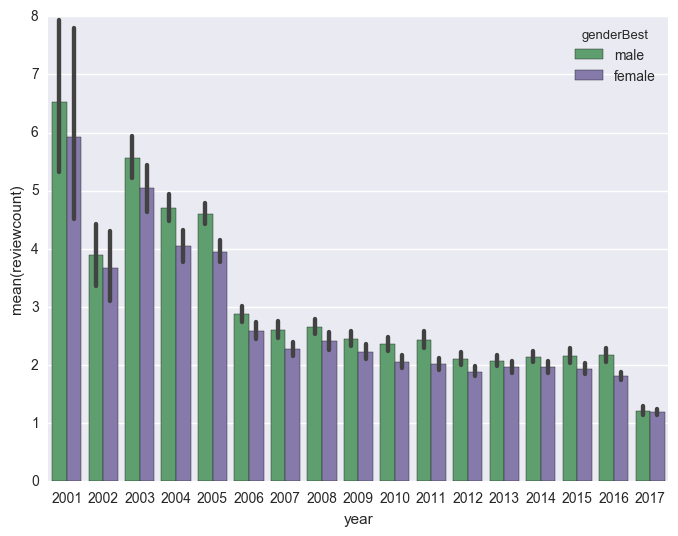

In [303]:
# could this be related to length of time available to review
# first total reviews by year

#note that RMP declined in use pretty steadily since 2004 and it's high points were 2001 and 2003

size=(8, 6)
sns.barplot(x="year", y="reviewcount", hue = "genderBest", data=yearProf_df,
              palette={"male": "g", "female": "m"});

# Impact of Grade on Ratings

In [11]:
# Get rid of grade value oddities
review_df.replace({'grade':{'Grade':'Unknown','yet':'Unknown','none yet':'Unknown',450:'Unknown'}},inplace=True)

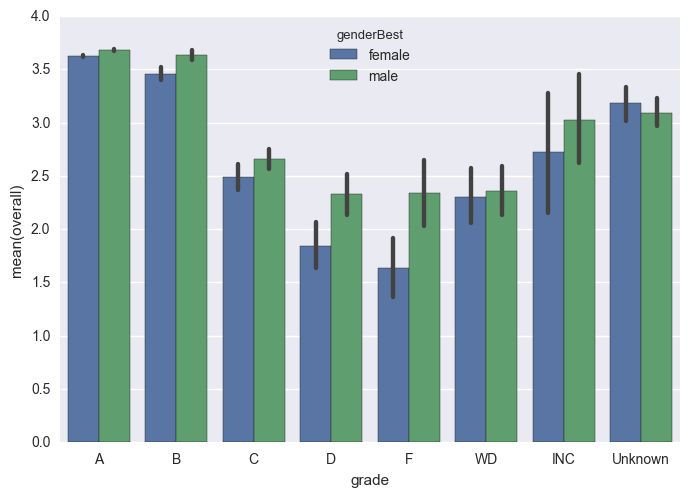

In [26]:
# low grades are correlated with low overall rating, but bad grades seem to hit female teachers more
sns.set(font_scale=1)
sns.barplot(x="grade", y="overall", hue = 'genderBest',order=['A','B','C','D','F','WD','INC','Unknown'],data=review_df);

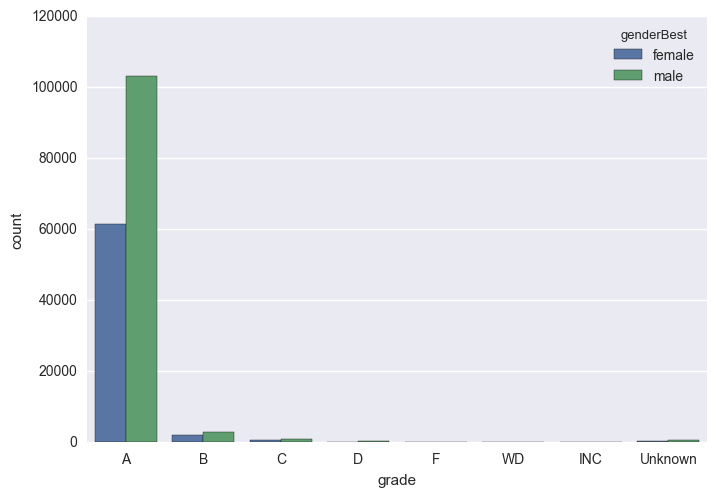

In [27]:
# That's a lot of A's
sns.set(font_scale=1)
sns.countplot(x="grade", hue = 'genderBest',order=['A','B','C','D','F','WD','INC','Unknown'],data=review_df);

# Overall vs. Difficulty

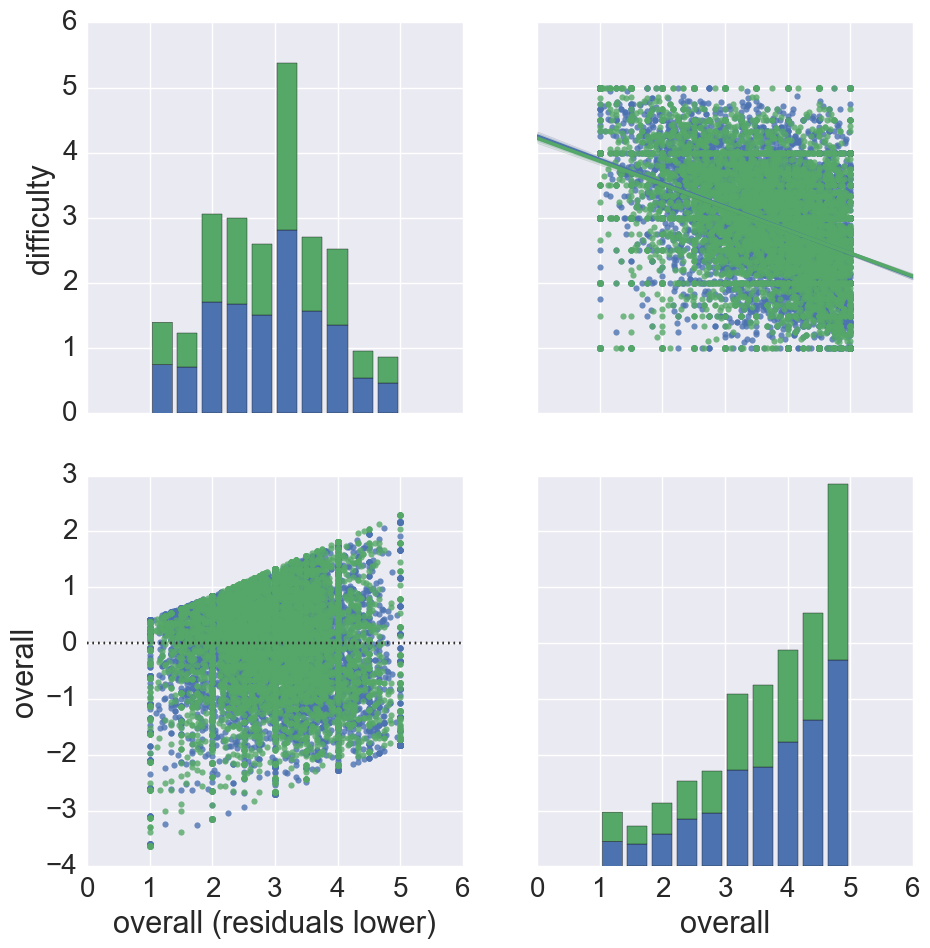

In [19]:
# Difficulty vs Overall for men & women
g = sns.PairGrid(groupProf_df[["difficulty", "overall","genderBest"]], size =5,hue="genderBest")  
g.set(alpha=0.001)  
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(plt.hist)
g.axes[1,0].xaxis.set_label_text("overall (residuals lower)")
sns.set(font_scale=2)


# Distribution of overall

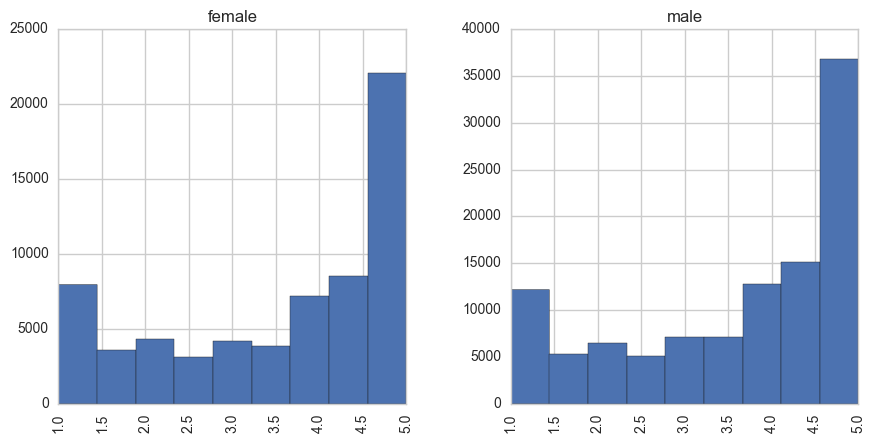

In [417]:
plt.rcParams["figure.figsize"] = [10,5]
plt.figure()
review_df.hist(by='genderBest',column = 'overall',bins = 9)
plt.show()

# Overall and Difficulty by Department

Dataset has department for course listed for each review. However, these are not standardized. Eventually, I would like to do some automatic grouping by department. For now, dropping departments with very few reviews.

In [43]:
#grab all of the fields, do the overall (not by gender), include counts of all
dept_df = review_df[['department','genderBest','overall','difficulty']].groupby(['department','genderBest']).mean().unstack()
dept_df = pd.DataFrame(dept_df.to_records())
cnt_df = review_df[['department','genderBest','amazing']].groupby(['department','genderBest']).count().unstack()
cnt_df = pd.DataFrame(cnt_df.to_records())
allDept_df =review_df[['department','overall','difficulty','amazing']].groupby(['department']).agg({'overall' : 'mean','difficulty':'mean','amazing':'count'}).reset_index()

dept_df = pd.merge(dept_df, cnt_df, on='department')
dept_df.rename(columns = {"('overall', 'female')":'overallFemale',"('overall', 'male')":'overallMale',"('difficulty', 'female')":'difficultyFemale',"('difficulty', 'male')":'difficultyMale',"('amazing', 'female')":'countFemale',"('amazing', 'male')":'countMale'},inplace=True)
dept_df = pd.merge(dept_df,allDept_df,on='department')
dept_df.rename(columns = {'overall':'overallMF','difficulty':'difficultyMF','amazing':'countMF'},inplace=True) 

In [44]:
#drop NAs and anyth department having fewer than 20 prof
deptClean = dept_df.dropna().reset_index()
deptClean.drop(deptClean[deptClean.countFemale<30].index,inplace=True)
deptClean.drop(deptClean[deptClean.countMale<30].index,inplace=True)


In [45]:
#columns to compare male/female
deptClean['overallDiff']=deptClean['overallFemale']-deptClean['overallMale']
deptClean['difficultyDiff']=deptClean['difficultyFemale']-deptClean['difficultyMale']
deptClean['countRatioFM']=(deptClean['countFemale']-deptClean['countMale'])/(deptClean['countFemale']+deptClean['countMale'])


In [46]:
#difficulty vs overall
deptClean['doRatioAll'] = deptClean['overallMF']/deptClean['difficultyMF']
deptClean['doRatioMale'] = deptClean['overallMale']/deptClean['difficultyMale']
deptClean['doRatioFemale'] = deptClean['overallFemale']/deptClean['difficultyFemale']


In [47]:
cols = ['index', 'department', 'overallFemale', 'overallMale', 'overallDiff',
       'difficultyFemale', 'difficultyMale', 'difficultyDiff','doRatioAll','doRatioFemale','doRatioMale','countFemale', 'countMale',
       'overallMF', 'difficultyMF', 'countMF','countRatioFM']

In [48]:
deptClean = deptClean[cols]

Here looking at mean difficulty and overall by department (so all professors in department aggregated). Difficulty and overall remain well correlated. Note for women the scores are in a narrower band (and this may simply have to do with fewer female ratings, have not explored yet).

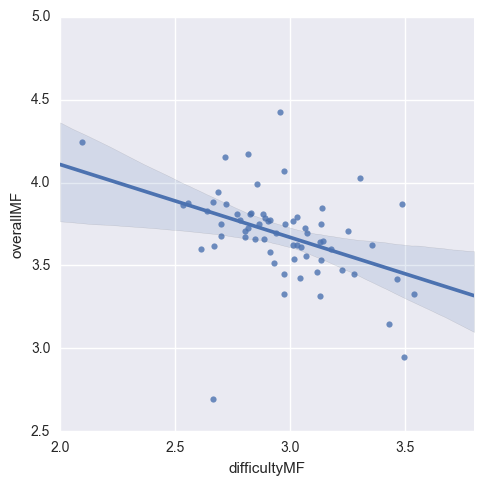

In [49]:
# This is for everyone (male and female)
sns.lmplot(x='difficultyMF',y='overallMF',data=deptClean);

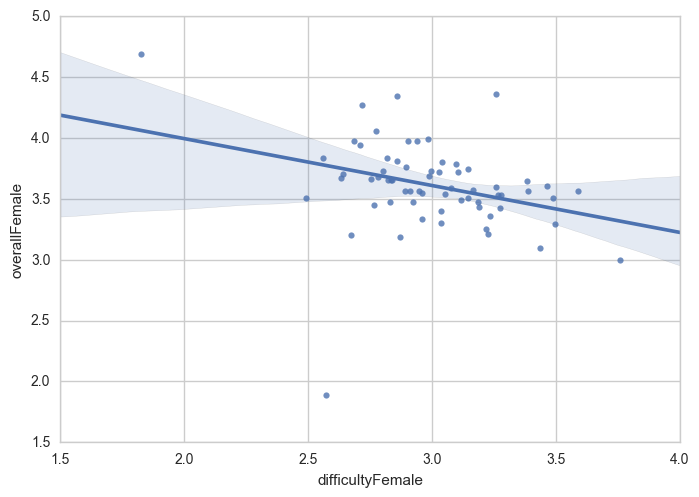

In [393]:
sns.regplot(x="difficultyFemale", y="overallFemale", data=deptClean);

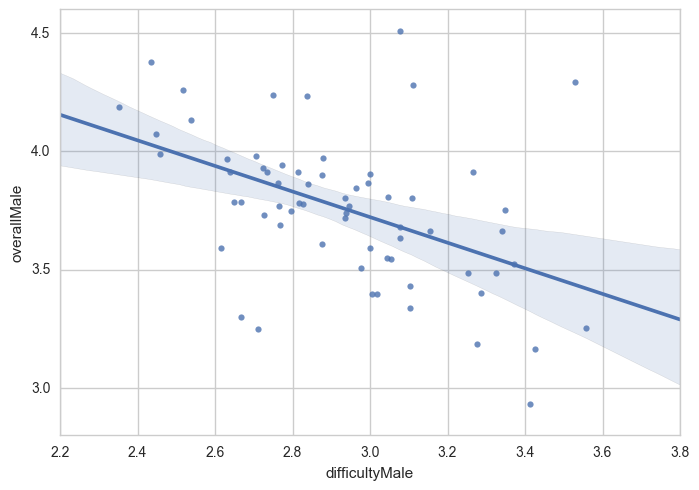

In [394]:
sns.regplot(x="difficultyMale", y="overallMale", data=deptClean);

Interested in looking at overall scores and difficulty by department and gender. Plot below has some promise, but is a little too difficult to read and get a story from. 

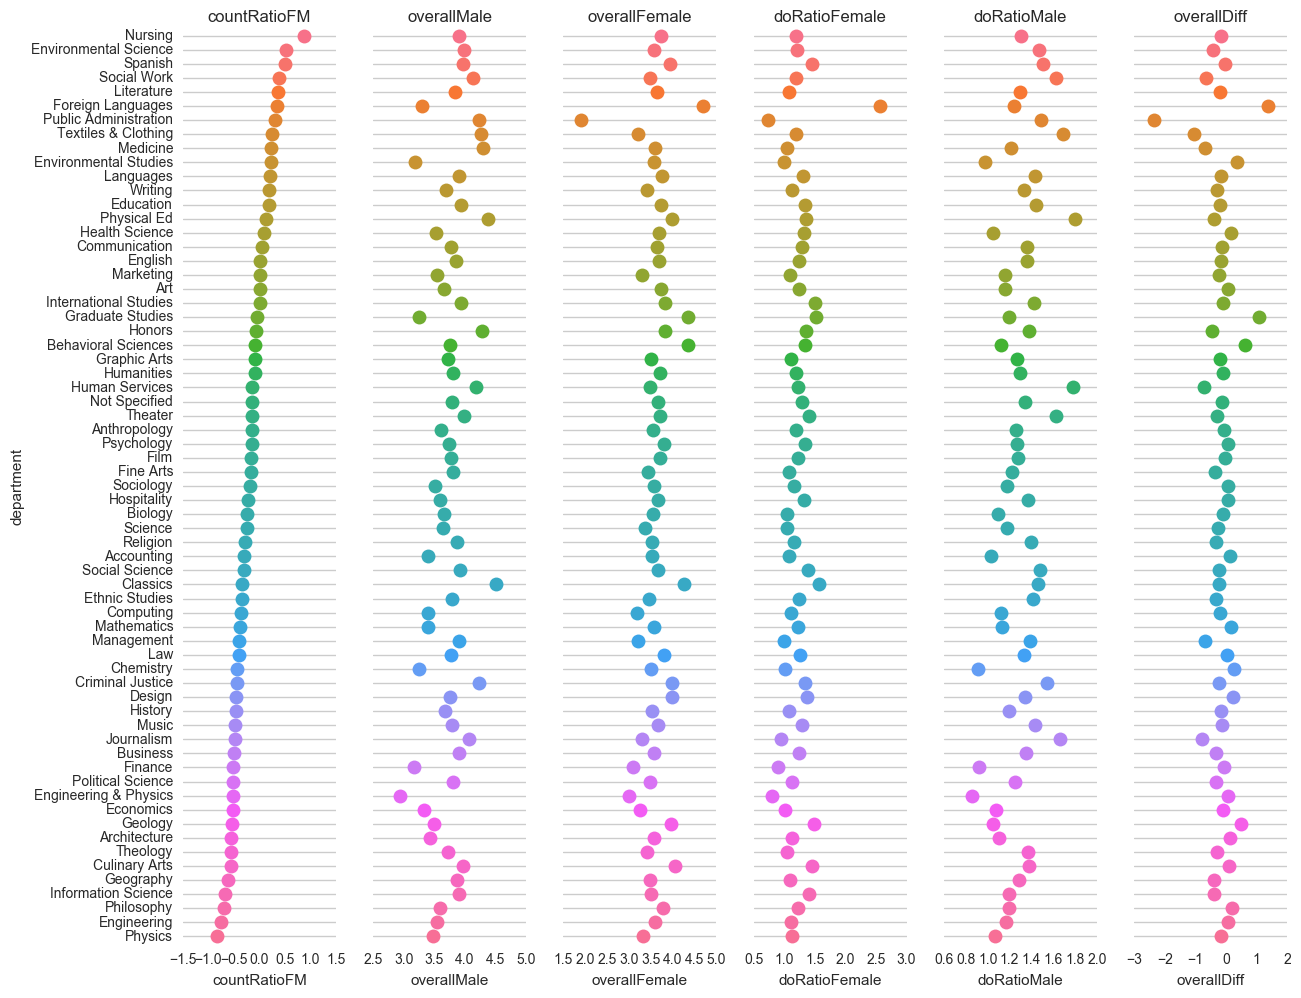

In [398]:
sns.set(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(deptClean.sort_values("countRatioFM", ascending=False),
                 x_vars=['countRatioFM','overallMale','overallFemale','doRatioFemale','doRatioMale','overallDiff'], y_vars=["department"],
                 size=10, aspect=.2)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="husl", edgecolor="gray")

## Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles =['countRatioFM','overallMale','overallFemale','doRatioFemale','doRatioMale','overallDiff']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)


# Review Text

Unpacking first some information about the vocabulary, lexical diversity, and pronoun use in the reviews.

In [50]:
review_df['wordcount']=review_df['cleanText'].apply(len)

In [65]:
review_df['selfPronRate']=review_df['selfPronCnt']/review_df['wordcount']

In [4]:
#lexical diversity for each review
def lexDiversity(text):
    if len(text)==0:
        ld = 0
    else:
        ld = len(text)/len(set(text))
    return ld
review_df['lexDiversity']=review_df['cleanText'].apply(lexDiversity)

Overall, people are writing more words about female profs and using more pronouns.

In [66]:
review_df[['genderBest','wordcount','selfPronCnt','selfPronRate']].groupby('genderBest').mean()

,wordcount,selfPronCnt,selfPronRate
genderBest,,,
female,184.340916,2.07872,0.010632
male,179.049301,1.88687,0.009634


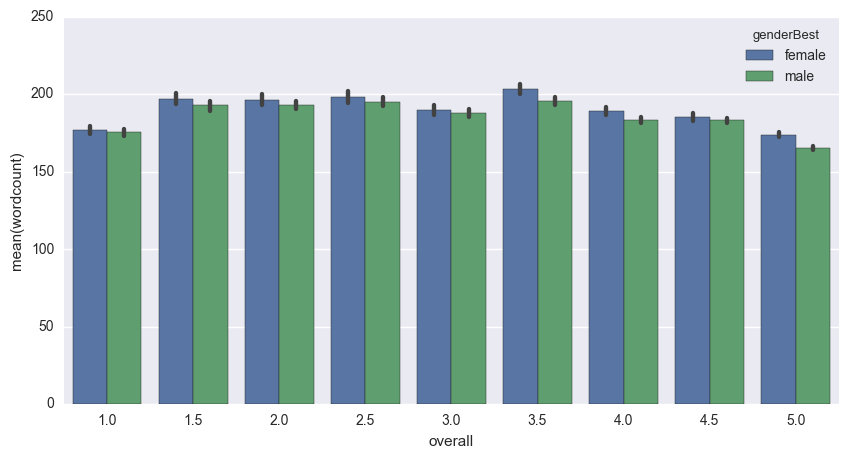

In [64]:
# Average wordcount  by Gender and rating
sns.barplot(x="overall", y='wordcount', hue = "genderBest", data=review_df);


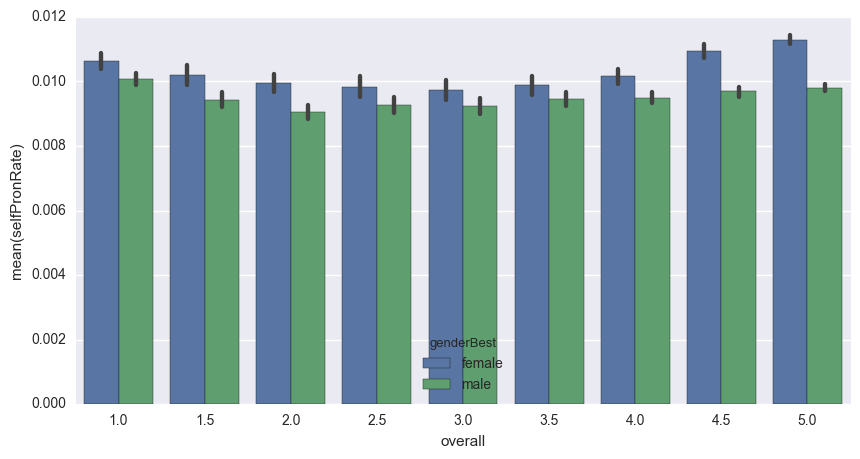

In [70]:
# Average selfPronRate  by Gender and rating
sns.barplot(x="overall", y='selfPronRate', hue = "genderBest", data=review_df);


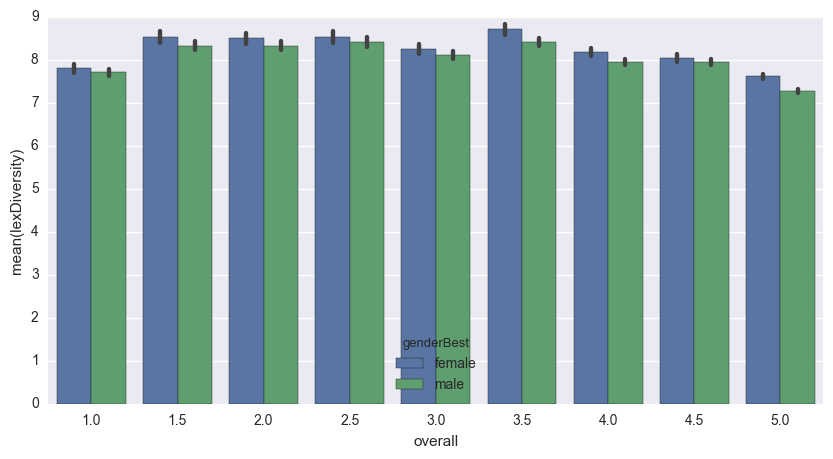

In [62]:
# Average lexDiversity by Gender and rating
sns.barplot(x="overall", y='lexDiversity', hue = "genderBest", data=review_df);


What about the content being written? If we remove stopwords, we can see both the length of the content and the fractation of total text.

In [7]:
def content(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [word for word in text if word.lower() not in stopwords]
    return content

def content_fraction(text):
    contents = content(text)
    return len(contents)/len(text)

In [8]:
review_df['content']=review_df['cleanText'].apply(content)
review_df['contentFrac']=review_df['cleanText'].apply(content_fraction)

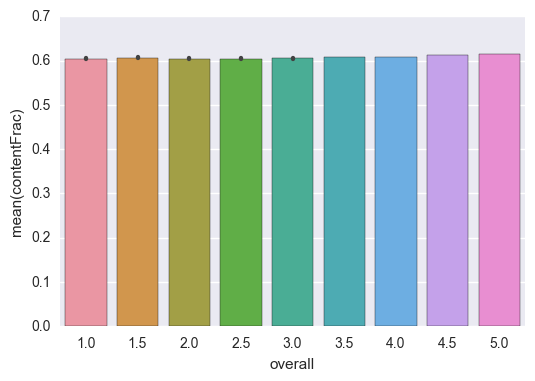

In [12]:
# Average lexDiversity by Gender and rating
# shows no real gender differences but increases very minimally as overall goes up
sns.barplot(x="overall", y='contentFrac', hue = "genderBest", data=review_df);
